In [44]:
import os
import json
import glob
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
import random

In [45]:
# store all file names in PATH in a list
tiffs = []
for file in os.listdir("../public_data/"):
    if file.endswith(".tiff"):
        tiffs.append(file)

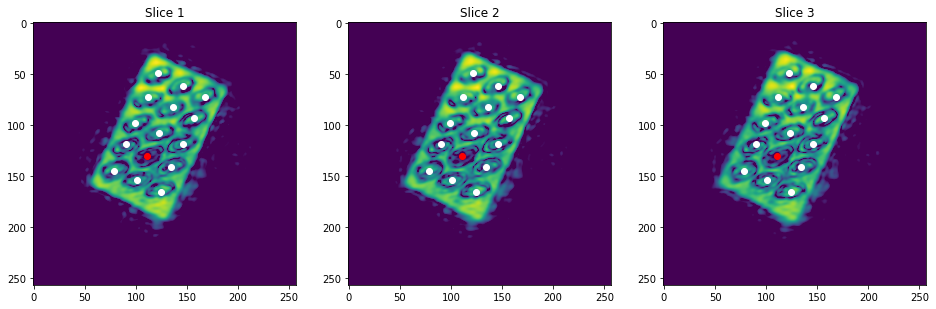

In [154]:
def load_img(path):
    return skimage.io.imread(path)

filename = random.choice(tiffs)
input_file = "../public_data/" + filename
img_array = load_img(f'{input_file}')

label = None

if label is None:
    label_filename = input_file.replace('.tiff', '.json')
    if os.path.exists(label_filename):
        with open(label_filename, 'r') as file:
            label = json.loads(file.read())

# plot the image
fig, axs = plt.subplots(1, 3, figsize=(16, 7))
for i in range(img_array.shape[2]):
    volume = 20 * np.log10(img_array[:, :, i])
    max_val = np.max(volume)
    axs[i].imshow(volume, vmax=max_val, vmin=max_val - 25)
    axs[i].set_title(f"Slice {i + 1:d}")

    if label is not None:
        x_coords = [coord[0] for coord in label['coordinates']['present']]
        y_coords = [257-coord[1] for coord in label['coordinates']['present']]
        axs[i].scatter(x_coords, y_coords, color='white')

        x_coords = [coord[0] for coord in label['coordinates']['missing']]
        y_coords = [257 - coord[1] for coord in label['coordinates']['missing']]
        axs[i].scatter(x_coords, y_coords, color='red')

plt.show()

In [73]:
import cv2

for i in range(img_array.shape[2]):
    volume = 20 * np.log10(img_array[:, :, i])
    max_val = np.max(volume)
    volume = (volume - max_val + 25) / 25
    cv2.imshow('img', volume)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [137]:
import cv2

print(img_array.shape[2])

img_gray = cv2.cvtColor(img_array*100, cv2.COLOR_BGR2GRAY).astype('uint8')

# threshold the image
ret, thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY_INV)

cv2.imshow('img', thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

3


In [182]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [204]:
label_filename = input_file.replace('.tiff', '.json')
if os.path.exists(label_filename):
    with open(label_filename, 'r') as file:
        label = json.loads(file.read())

# img_gray = cv2.cvtColor(img_array*100, cv2.COLOR_BGR2GRAY).astype('uint8')
ret, thresh = cv2.threshold(img_array*100, 45, 255, cv2.THRESH_BINARY_INV)

present = label["coordinates"]["present"]
missing = label["coordinates"]["missing"]

for x, y in present:
    width = 30
    height = 20
    cv2.rectangle(thresh, (int(x) - width//2, 257-int(y) - height//2), (int(x) + width//2, 257-int(y) + height//2), (0, 255, 0), 3)

for x, y in missing:
    width = 30
    height = 20
    cv2.rectangle(thresh, (int(x) - width//2, 257-int(y) - height//2), (int(x) + width//2, 257-int(y) + height//2), (0, 0, 255), 3)

cv2.imshow('img', thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [210]:
img_width = img_array.shape[1]
img_height = img_array.shape[0]

width = 30 / img_width
height = 20 / img_height



for filename in tiffs:
    label_filename = "../public_data/" + filename.replace('.tiff', '.json')
    if os.path.exists(label_filename):
        with open(label_filename, 'r') as file:
            label = json.loads(file.read())
    else:
        continue
    present = label["coordinates"]["present"]
    missing = label["coordinates"]["missing"]
    with open(f"../public_data/{filename.replace('.tiff', '.txt')}", "w") as fo:
        for x, y in present:
            fo.write(f"1 {x/img_width} {(257 - y) / img_height} {width} {height}\n")
        for x, y in missing:
            fo.write(f"0 {x/img_width} {(257 - y) / img_height} {width} {height}\n")

    img_array = load_img(f'../public_data/{filename}')
    img_gray = cv2.cvtColor(img_array*100, cv2.COLOR_BGR2GRAY).astype('uint8')
    cv2.imwrite(f"../public_data/{filename.replace('.tiff', '.png')}", img_gray)


In [169]:
from PIL import Image, ImageDraw

random.seed(0)

# Dictionary that maps class names to IDs
class_id_to_name_mapping = {1: "present",
                            0: "missing"}

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = filename.replace('.tiff', '.txt')
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = filename.replace('.tiff', '.png')
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

FileNotFoundError: [Errno 2] No such file or directory: 'ffdc3639727e3c456d6d2c2ca6463ae4.txt'

In [212]:
from sklearn.model_selection import train_test_split

# Read images and annotations
images = [os.path.join('../public_data/', x) for x in os.listdir('../public_data/') if x[-3:] == "png"]
annotations = [os.path.join('../public_data/', x) for x in os.listdir('../public_data/') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [213]:
import os

os.mkdir("../images")
os.mkdir("../labels")

os.mkdir("../images/train")
os.mkdir("../images/test")
os.mkdir("../images/val")

os.mkdir("../labels/train")
os.mkdir("../labels/test")
os.mkdir("../labels/val")

In [214]:
import shutil

#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '../images/train')
move_files_to_folder(val_images, '../images/val/')
move_files_to_folder(test_images, '../images/test/')
move_files_to_folder(train_annotations, '../labels/train/')
move_files_to_folder(val_annotations, '../labels/val/')
move_files_to_folder(test_annotations, '../labels/test/')

In [ ]:
print("Moritz suckt gerne dicke Pimmel\n")
print("…………………...„„-~^^~„-„„_", "………………„-^*'' : : „'' : : : : *-„", "…………..„-* : : :„„--/ : : : : : : : '\\", ": : „-* . .| : : : : : : : : '|", "……….../ : „-* . . . | : : : : : : : : |", "………...\„-* . . . . .| : : : : : : : :'|", "……….../ . . . . . . '| : : : : : : : :|", "……..../ . . . . . . . .'\ : : : : : : : |", "……../ . . . . . . . . . .\ : : : : : : :|", "……./ . . . . . . . . . . . '\ : : : : : /", "….../ . . . . . . . . . . . . . *-„„„„-*'", "….'/ . . . . . . . . . . . . . . '|", "…/ . . . . . . . ./ . . . . . . .|", "../ . . . . . . . .'/ . . . . . . .'|", "./ . . . . . . . . / . . . . . . .'|", "'/ . . . . . . . . . . . . . . . .'|", "'| . . . . . \ . . . . . . . . . .|", "'| . . . . . . \„_^- „ . . . . .'|", "'| . . . . . . . . .'\ .\ ./ '/ . |", "| .\ . . . . . . . . . \ .'' / . '|", "| . . . . . . . . . . / .'/ . . .|", sep="\n")



In [215]:
!python ./yolov5/train.py --img 257 --hyp hyp.scratch.yaml --batch 128 --epochs 10 --data pills.yaml --workers 16 --name yolo_pills_det --device 0


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=pills.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=257, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5\runs\train, name=yolo_pills_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v6.1-161-ge54e758 torch 1.11.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=